# **Loading the dataset**

In [1]:
import pandas as pd
data = pd.read_csv("final_data.csv")

In [2]:
data.head()

,name,brewery_type,city,country,longitude,latitude,state,address,delivery,dine_in,curbside_pickup,reservable,takeout,wheelchair_accessible_entrance,rating,price_level,reviews
0,6th and La Brea,brewpub,los_angeles,United States,-118.344021,34.073048,California,"101 S La Brea Ave, Los Angeles, CA 90036, USA",1.0,1.0,-1.0,0.0,1.0,1.0,4.5,3.0,['Ordered carry-out from Sugarfish since I hea...
1,Arts District Brewing Company,brewpub,los_angeles,United States,-118.235703,34.045054,California,"811 Traction Ave, Los Angeles, CA 90013, USA",1.0,1.0,-1.0,0.0,1.0,1.0,4.5,2.0,['I’ve gad their coffee before at grocery stor...
2,Bonaventure Brewing Co,brewpub,los_angeles,United States,-118.256211,34.053146,California,"404 S Figueroa St, Los Angeles, CA 90071, USA",-1.0,-1.0,-1.0,-1.0,1.0,1.0,5.0,-1.0,"['hot dog good price', ""Well... it's not that ..."
3,Boomtown Brewery,micro,los_angeles,United States,-118.233179,34.050771,California,"530 Ramirez St, Los Angeles, CA 90012, USA",1.0,1.0,1.0,0.0,1.0,1.0,3.9,1.0,"[""I came today with my two adult kids for brea..."
4,Eagle Rock Brewery,micro,los_angeles,United States,-118.244038,34.114731,California,"3040 Roswell St, Los Angeles, CA 90065, USA",0.0,-1.0,-1.0,-1.0,-1.0,1.0,3.9,-1.0,['Peruvian event was there nice . Fou d recaud...


# **Model 1: Gradient Boost Regressor**

## Importing the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

## Data Preparation

In [4]:
X = data[['delivery', 'dine_in', 'curbside_pickup', 'reservable', 'takeout', 'wheelchair_accessible_entrance']]
y = data['rating']


## Splitting the data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Initialization and Hyperparameter Tuning

In [6]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gb_model = GradientBoostingRegressor()

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


## Model Evaluation on Test Data

In [7]:
best_gb_model = grid_search.best_estimator_

y_pred_gb = best_gb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_gb)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.06677011912319515


## Feature Importance Analysis

In [8]:
feature_importance = best_gb_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                          Feature  Importance
0                        delivery    0.638967
3                      reservable    0.198285
2                 curbside_pickup    0.071181
5  wheelchair_accessible_entrance    0.046718
1                         dine_in    0.024285
4                         takeout    0.020564


## Plotting Feature Importance

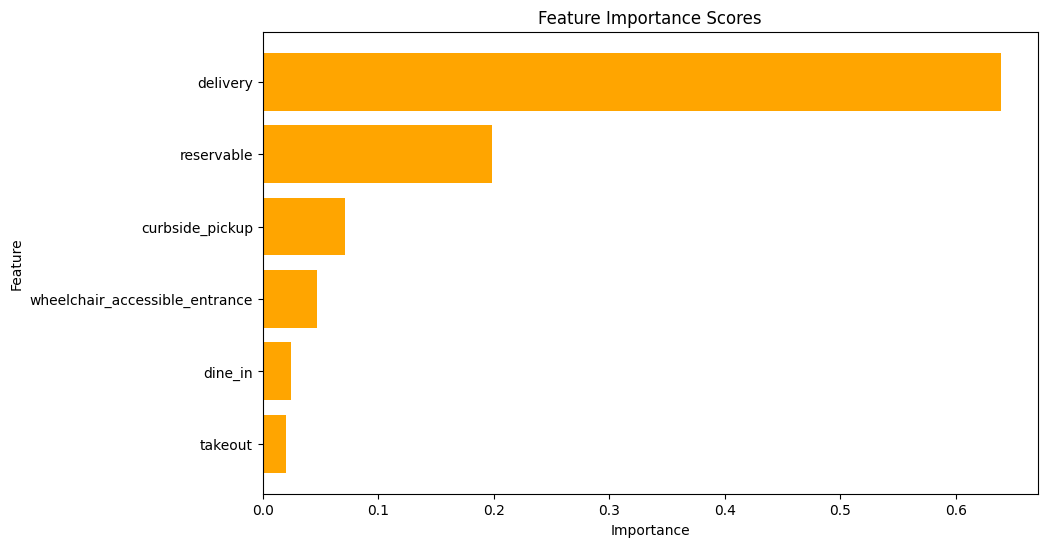

In [9]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='orange')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Scores')
plt.gca().invert_yaxis()
plt.show()

## Deviance Plot

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


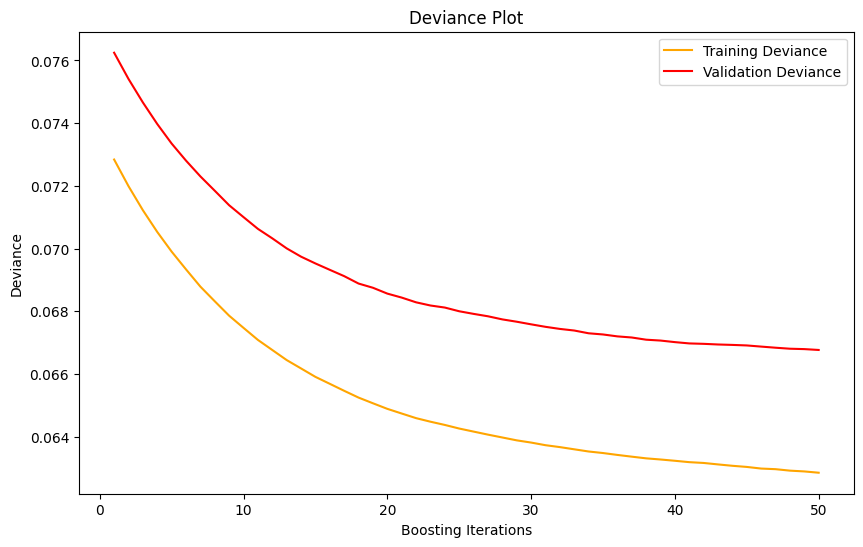

In [10]:
train_deviance = best_gb_model.train_score_
valid_deviance = np.empty(len(train_deviance))

for i, y_pred in enumerate(best_gb_model.staged_predict(X_test)):
    valid_deviance[i] = best_gb_model.loss_(y_test, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(train_deviance) + 1), train_deviance, label='Training Deviance', color='orange')
plt.plot(np.arange(1, len(valid_deviance) + 1), valid_deviance, label='Validation Deviance', color='red')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.title('Deviance Plot')
plt.legend()
plt.show()

The deviation plot shows a comparison between the training and validation deviance. The training deviance is higher than the validation deviance, which suggests that the model is overfitting the training data.

## Cross-Validation Scores

In [11]:
cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

Cross-Validation Scores: [0.0638714  0.06606094 0.06430835 0.06606741 0.05901176]
Mean CV Score: 0.06386397302825067
Standard Deviation of CV Scores: 0.0025854706952964535


# **Model 2: K-Nearest Neighbours**

## Importing necessary libraries

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Data Preparation

In [13]:
X = data.drop(columns=['rating'])
y = data['rating']

## Data Splitting

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled = scaler.transform(X_test[numeric_columns])

## Model Training

In [15]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train_scaled, y_train)


KNeighborsRegressor(n_neighbors=10)

## Model Evaluation

In [16]:
y_pred = knn.predict(X_test_scaled)

accuracy = r2_score(y_test, y_pred)
print("R-squared (Accuracy):", accuracy)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

R-squared (Accuracy): 0.12476071405555189
Mean Squared Error: 0.0675536312849162


## Visualization

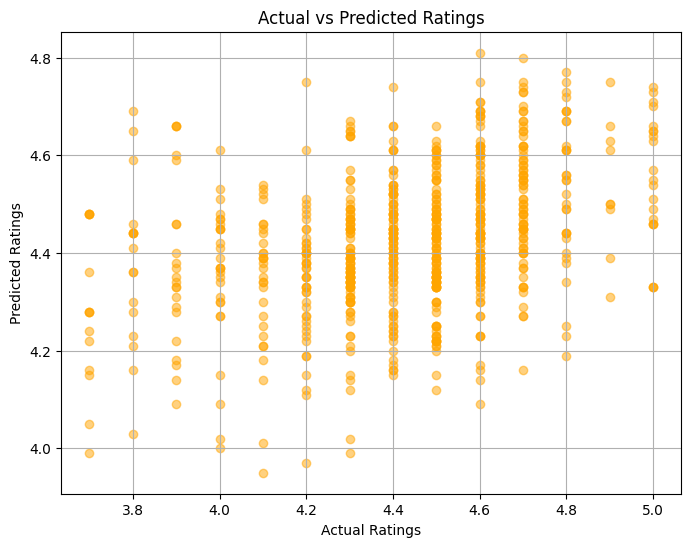

In [73]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='orange', alpha=0.5)
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.show()

The graph shows the difference between the actual and predicted ratings of a movie. The actual ratings are generally higher than the predicted ratings, and there is no consistent pattern in the residuals, which suggests a good fit for the model.

# **Model 3: Sentiment Analysis**

## Importing necessary libraries

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

In [75]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Sentiment Analysis

In [76]:
sid = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['reviews'].apply(lambda x: sid.polarity_scores(x)['compound'])

## Text Feature Extraction

In [77]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_text_features = tfidf_vectorizer.fit_transform(data['reviews']).toarray()

## Sentiment Score Transformation

In [78]:
X_sentiment = np.array(data['sentiment_score']).reshape(-1, 1)

## Combined Features

In [79]:
X_combined = np.concatenate((X_text_features, X_sentiment), axis=1)

## Splitting Data and Target Variables

In [82]:
y = data['rating']
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

## Model Training

In [81]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Model Evaluation

In [83]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Training R^2 score: {train_score}")
print(f"Testing R^2 score: {test_score}")

Training R^2 score: 0.9307107081543113
Testing R^2 score: 0.5722145151222948


## Visualization

### Scatter plot of Actual vs. Predicted Ratings

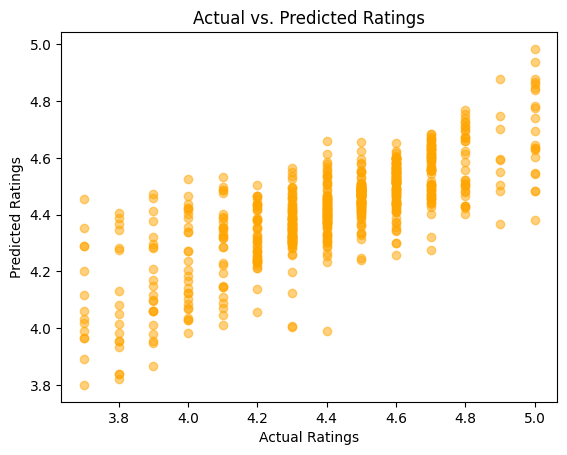

In [84]:
import matplotlib.pyplot as plt

plt.scatter(y_test, model.predict(X_test), color = "orange", alpha = 0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.show()

The graph shows a comparison between predicted and actual ratings. The predicted ratings are consistently higher than the actual ratings. This suggests that the model might be overestimating the ratings.

### Residual Plot

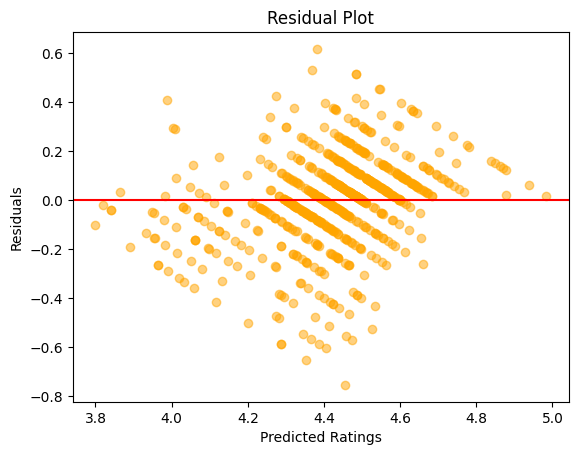

In [85]:
plt.scatter(model.predict(X_test), y_test - model.predict(X_test),color = "orange", alpha = 0.5)
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


This residual plot shows the difference between the actual ratings and the model's anticipated ratings on the y-axis, as well as the predicted ratings themselves on the x-axis.

The random spread of the residuals around zero with constant vertical variation suggests the model effectively captures the data's trend without violating key assumptions.

### Scatter plot with diagonal line

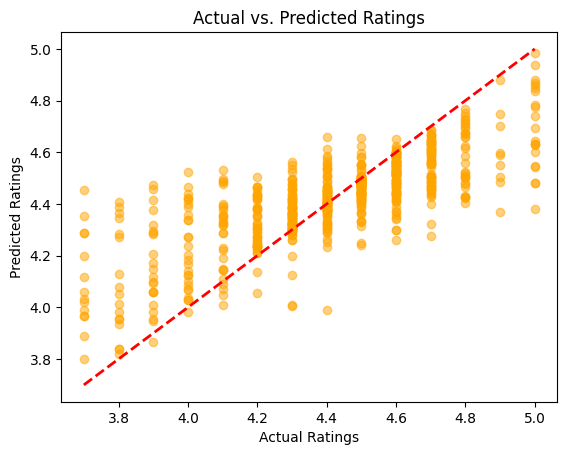

In [86]:
predicted_ratings = model.predict(X_test)
plt.scatter(y_test, predicted_ratings, color = "orange", alpha = 0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.show()

# **Model 4: Neural Networks**

## Importing necessary libraries

In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

##  Dropping irrelevant columns

In [98]:
data = pd.read_csv("final_data.csv")

In [99]:
data = data.drop(['name', 'reviews', 'address'], axis=1)

## Splitting data

In [100]:
X = data.drop(['rating'], axis=1)
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Preprocessing pipeline

In [101]:
categorical_cols = ['brewery_type', 'city', 'country', 'state']
numerical_cols = list(set(X.columns) - set(categorical_cols))

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

preprocessor.fit(X_train)


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['reservable', 'takeout', 'curbside_pickup',
                                  'price_level', 'dine_in',
                                  'wheelchair_accessible_entrance', 'delivery',
                                  'latitude', 'longitude']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['brewery_type', 'city', 'country', 'state'])])

## Transforming training and testing data

In [102]:
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [103]:
X_train_preprocessed = X_train_preprocessed.toarray()
X_test_preprocessed = X_test_preprocessed.toarray()

## Defining a Sequential model

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Defining a Sequential model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1)
])




## Compiling the model

In [105]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

## Model Training

In [106]:
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train_preprocessed, y_train, test_size=0.2, random_state=42)


In [107]:
history = model.fit(X_train_final, y_train_final, epochs=50, batch_size=32, validation_data=(X_val_final, y_val_final), verbose=1)

Epoch 1/50
72/72 [==============================] - 1s 7ms/step - loss: 6.3924 - val_loss: 0.3478
Epoch 2/50
72/72 [==============================] - 0s 5ms/step - loss: 1.2495 - val_loss: 0.1554
Epoch 3/50
72/72 [==============================] - 0s 5ms/step - loss: 1.0762 - val_loss: 0.1580
Epoch 4/50
72/72 [==============================] - 0s 5ms/step - loss: 0.9691 - val_loss: 0.1841
Epoch 5/50
72/72 [==============================] - 0s 5ms/step - loss: 0.9448 - val_loss: 0.1189
Epoch 6/50
72/72 [==============================] - 0s 6ms/step - loss: 0.8858 - val_loss: 0.1545
Epoch 7/50
72/72 [==============================] - 0s 5ms/step - loss: 0.8677 - val_loss: 0.1394
Epoch 8/50
72/72 [==============================] - 0s 5ms/step - loss: 0.8184 - val_loss: 0.1261
Epoch 9/50
72/72 [==============================] - 0s 5ms/step - loss: 0.8213 - val_loss: 0.1128
Epoch 10/50
72/72 [==============================] - 0s 5ms/step - loss: 0.8206 - val_loss: 0.1176
Epoch 11/50
72/72 [

## Model Evaluation

In [108]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test_preprocessed)

23/23 [==============================] - 0s 2ms/step


## Calculating Mean Squared Error and R-squared

In [109]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.09319856287371964
R-squared: -0.2075005009961146


## Training and Validation Loss Plot

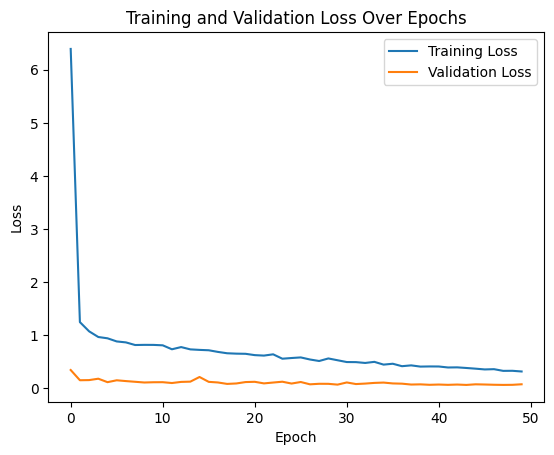

In [110]:
import matplotlib.pyplot as plt

# Plotting training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


The graph shows training and validation loss over epochs, which are iterations over the training data. The training loss tends to decrease as the model learns the training data, while the validation loss indicates how well the model performs on unseen data. In the ideal scenario, the training loss decreases and the validation loss remains flat, which suggests the model is learning the underlying trend without overfitting the training data

## Data Distribution Visualization

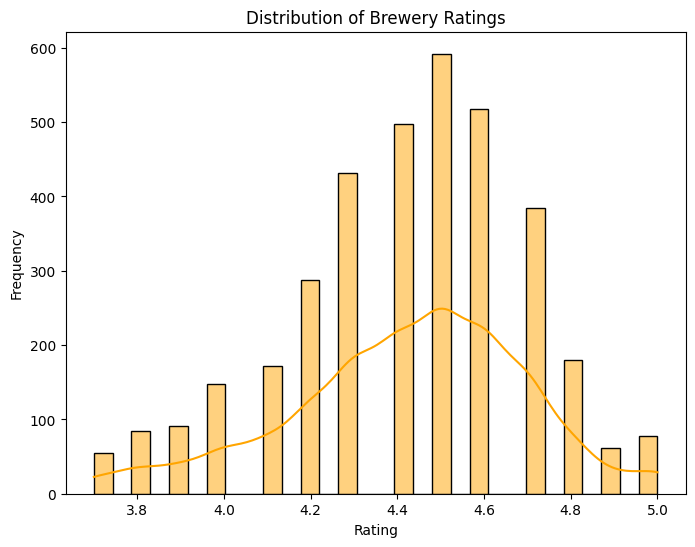

In [111]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True, color='orange', bins=30)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Brewery Ratings')
plt.show()


# **Model 5: XGBoost regressor**

## Data Preprocessing

In [112]:
df = pd.read_csv("final_data.csv")
df = df[~df['state'].isin(['Alaska', 'Hawaii'])]
df = df[df['country'] == 'United States']
df.drop(columns = 'state', inplace = True)

## Handling Missing Values and Data Transformation

In [113]:
def impute_category(df, col_name):
    mode = df[col_name][df[col_name] >= 0].mode()[0]
    df[col_name] = df[col_name].apply(lambda x: mode if x < 0 else x)
    df[col_name] = df[col_name].astype('int')

impute_category(df, 'delivery')
impute_category(df, 'dine_in')
impute_category(df, 'curbside_pickup')
impute_category(df, 'reservable')
impute_category(df, 'takeout')
impute_category(df, 'wheelchair_accessible_entrance')

median_price = df['price_level'][df['price_level'] >= 0].median()
df['price_level'] = df['price_level'].apply(lambda x: median_price if x < 0 else x)
df['price_level'] = df['price_level'].astype('int')

## Feature Selection

In [114]:
df = df[['brewery_type', 'longitude', 'latitude', 'delivery', 'dine_in', 'curbside_pickup',
         'reservable', 'takeout', 'wheelchair_accessible_entrance', 'price_level', 'rating']]

## Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

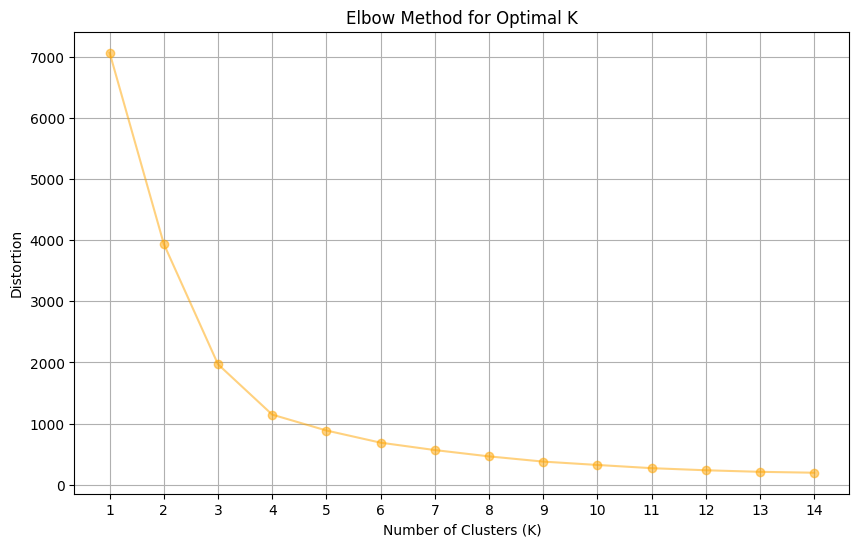

In [116]:
from sklearn.preprocessing import StandardScaler

coordinates = df[['longitude', 'latitude']]
from sklearn.cluster import KMeans

seed = 350

k_values = range(1, 15)

distortions = []

scaler = StandardScaler()
scaled_coordinates = scaler.fit_transform(coordinates)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(scaled_coordinates)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, distortions, marker='o',color="orange", alpha=0.5)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Through the elbow method, we use the distortion metric as our evaluation criteria to find the ideal number of clusters in our dataset. K-means clustering is used for different cluster numbers of k ranging from 1 to 15. From the graph we see that after k = 4, the decrease in distortion is negligent, and we can assume that all our breweries in our dataset can be grouped into ideally 4 clusters.

## K-means Clustering

In [117]:
k = 4
kmeans = KMeans(n_clusters=k, random_state = seed)
kmeans.fit(scaled_coordinates)

cluster_labels = kmeans.labels_
df['cluster'] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Cluster Visualization

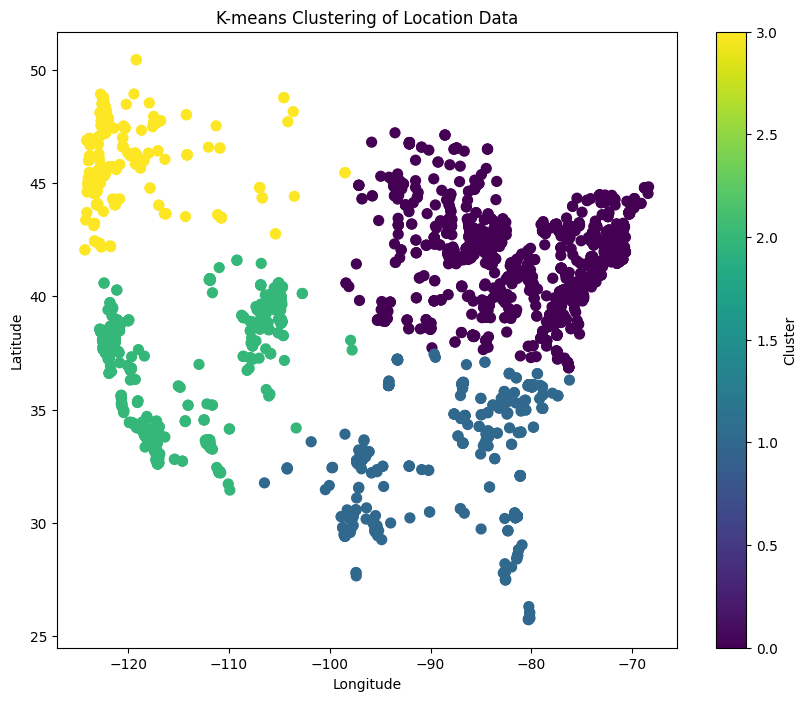

In [118]:
plt.figure(figsize=(10, 8))
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis', s=50)
plt.title('K-means Clustering of Location Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

Using the above k = 4 clusters, we plot the breweries using a scatter plot. The plot is visualised using longitude and latitude and represents the US map. The 4 clusters are mainly represented in the form of states being part of one among the north east, north west, south east and south west regions of the US continent.

## Data Preparation for Modeling

In [119]:
df = df.drop(columns = ['longitude', 'latitude'])

In [120]:
df_final = pd.get_dummies(df).astype('int')
df_final.head()

,delivery,dine_in,curbside_pickup,reservable,takeout,wheelchair_accessible_entrance,price_level,rating,cluster,brewery_type_brewpub,brewery_type_closed,brewery_type_contract,brewery_type_large,brewery_type_micro,brewery_type_nano,brewery_type_planning,brewery_type_proprietor,brewery_type_regional,brewery_type_taproom
0,1,1,1,0,1,1,3,4,2,1,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,1,2,4,2,1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,2,5,2,1,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,1,1,3,2,0,0,0,0,1,0,0,0,0,0
4,0,1,1,1,1,1,2,3,2,0,0,0,0,1,0,0,0,0,0


In [121]:
X = df_final.drop(columns = 'rating')
y = df_final['rating']

## Model Training and Evaluation

In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

In [123]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [124]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state = seed
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.07652474099068358
Root Mean Squared Error: 0.27663105572347363


## Model Evaluation by Cluster

In [125]:
unique_clusters = df_final['cluster'].unique()

In [126]:
y_actual_list = []
y_pred_list = []

for cluster in unique_clusters:

    temp_X_train = X_train[X_train['cluster'] == cluster]
    temp_train_index = X_train[X_train['cluster'] == cluster].index.values
    temp_y_train = y_train.loc[temp_train_index]

    temp_X_test = X_test[X_test['cluster'] == cluster]
    temp_test_index = X_test[X_test['cluster'] == cluster].index.values
    temp_y_test = y_test.loc[temp_test_index]

    y_actual_list.extend(temp_y_test)

    model.fit(temp_X_train, temp_y_train)
    y_pred = model.predict(temp_X_test)
    y_pred_list.extend(y_pred)

    print(f"Cluster {cluster}:")
    mse = mean_squared_error(temp_y_test, y_pred)
    print("Mean Squared Error:", mse)

    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)

Cluster 2:
Mean Squared Error: 0.07224022483861414
Root Mean Squared Error: 0.2687754171024838
Cluster 3:
Mean Squared Error: 0.08396365496663133
Root Mean Squared Error: 0.2897648270005028
Cluster 0:
Mean Squared Error: 0.07313464640880356
Root Mean Squared Error: 0.2704341812878016
Cluster 1:
Mean Squared Error: 0.08522642156064093
Root Mean Squared Error: 0.2919356462658182


## Overall Model Evaluation

In [127]:
mse = mean_squared_error(y_actual_list, y_pred_list)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.07639802968342513
Root Mean Squared Error: 0.2764019350211303


Creating indivdual models for each cluster finally gives a small improvement in performance but not by much. The RMSE score improves by 0.002
Eventhough this personalization improves model results, it is very small and we can conclude that clusters based on longitude and latitude does not play a role in customer's ratings of breweries.